# Colab settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!nvidia-smi

In [ ]:
%cd "drive/My Drive/satellite"
!pwd

# Import modules

In [1]:
import sys

sys.path.remove('/usr/local/lib/python3.9/site-packages')
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [2]:
import os
import glob
import pickle

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.resnet50 import ResNet50
from keras import backend as K

Using TensorFlow backend.


# Data preprocessing

## Set hyperparameters

In [7]:
PATCH_SIZE = 33
PATCH_MARGIN = PATCH_SIZE//2
OUTPUT_SIZE = 17 # Change by model
OUTPUT_MARGIN = OUTPUT_SIZE//2
CHANNEL_NUM = 3

SPACING = 10

h = 3569
w = 7910

val_h_threshold = h // 4
val_w_threshold = w // 2

test_h_threshold = h // 2
test_w_threshold = w // 2

city = 'otofuke'
save_dir = f'../sar_2_ndvi/sentinel/{city}/bin/patch'

In [6]:
num_rows = (h - (PATCH_SIZE//2)*2) // SPACING
num_cols = (w - (PATCH_SIZE//2)*2) // SPACING
print(num_rows * num_cols) # Number of all patches

17248


## Feature extraction and standarlization

In [12]:
def cal_ndvi(img_r, img_ir):
    return (img_ir - img_r) / (img_ir + img_r)

def standarlization(img_2d):
    return (img_2d - np.min(img_2d)) / (np.max(img_2d) - np.min(img_2d))

def feature_extraction(img):
    img_ndvi = cal_ndvi(img[4], img[5])
    img_vh = standarlization(img[0])
    img_vv = standarlization(img[1])
    img_elev = standarlization(img[6])
    img_std = np.array([img_ndvi, img_vh, img_vv, img_elev])
    return img_std

# def feature_extraction_hist(img):
#     _, h, v = img.shape
#     img_ndvi = cal_ndvi(img[4], img[5])
#     img_ndvi_hist, cdf = hist_equalization(img_ndvi, img_min=-1, img_max=1)
#     img_ndvi_hist = img_ndvi_hist.reshape(h, v)
#     img_vh = standarlization(img[0])
#     img_vv = standarlization(img[1])
#     img_elev = standarlization(img[6])
#     img_std = np.array([img_ndvi, img_vh, img_vv, img_elev])
#     img_std_hist = np.array([img_ndvi_hist, img_vh, img_vv, img_elev])
#     return img_std, img_std_hist, cdf

## Generate patch

In [13]:
def generate_patch(img, SPACING=SPACING):
    
    img_std = feature_extraction(img)
    
    train_patch = []
    val_patch = []
    test_patch = [] # For temporary test (Actual test uses patch with spacing=1)

    for i in range(num_rows):
        for j in range(num_cols):

            start_h = i*SPACING
            end_h = PATCH_SIZE+i*SPACING
            start_w = j*SPACING
            end_w = PATCH_SIZE+j*SPACING
            img_extracted = img_std[:,start_h:end_h, start_w: end_w]
            
            if end_h <= val_h_threshold or end_w <= val_w_threshold:
                train_patch.append(img_extracted)
            elif end_h <= test_h_threshold or end_w <= test_w_threshold:
                val_patch.append(img_extracted)
            else:
                test_patch.append(img_extracted)

    train_patch = np.array(train_patch)
    val_patch = np.array(val_patch)
    test_patch = np.array(test_patch)

    print(train_patch.shape)
    print(val_patch.shape)
    print(test_patch.shape)
    
    return train_patch, val_patch, test_patch


def generate_hist_patch(img, SPACING=SPACING):
    
    img_std, img_std_hist, cdf = feature_extraction_hist(img)
    
    train_patch = []
    val_patch = []
    test_patch = [] # For temporary test (Actual test uses patch with spacing=1)

    for i in range(num_rows):
        for j in range(num_cols):

            start_h = i*SPACING
            end_h = PATCH_SIZE+i*SPACING
            start_w = j*SPACING
            end_w = PATCH_SIZE+j*SPACING
            
            if end_h <= val_h_threshold or end_w <= val_w_threshold:
                img_extracted = img_std_hist[:,start_h:end_h, start_w: end_w]
                train_patch.append(img_extracted)
            elif end_h <= test_h_threshold or end_w <= test_w_threshold:
                img_extracted = img_std[:,start_h:end_h, start_w: end_w]
                val_patch.append(img_extracted)
            else:
                img_extracted = img_std[:,start_h:end_h, start_w: end_w]
                test_patch.append(img_extracted)

    train_patch = np.array(train_patch)
    val_patch = np.array(val_patch)
    test_patch = np.array(test_patch)

    print(train_patch.shape)
    print(val_patch.shape)
    print(test_patch.shape)
    
    return train_patch, val_patch, test_patch, cdf


def generate_all_patch(img, SPACING=SPACING):
    img_std = feature_extraction(img)
    
    all_patch = []
    
    for i in range(num_rows):
        for j in range(num_cols):

            start_h = i*SPACING
            end_h = PATCH_SIZE+i*SPACING
            start_w = j*SPACING
            end_w = PATCH_SIZE+j*SPACING
            img_extracted = img_std[:,start_h:end_h, start_w: end_w]
            
            all_patch.append(img_extracted)

    all_patch = np.array(all_patch)
    print(all_patch.shape)
    
    return all_patch

In [655]:
# For normal patch
city  = 'kansas'
img_list = glob.glob(f'../sar_2_ndvi/sentinel/{city}/bin/pixel_resized/*.npy')

for i, path in enumerate(img_list):
    idx = path[-8:-4]
    img = np.load(path)
    img = img[:7]
    
    train_patch, val_patch, test_patch = generate_patch(img)
    # all_patch_ = np.concatenate([train_patch, val_patch, test_patch])
    
    np.save(os.path.join(save_dir, f'train_{idx}.npy'), train_patch)
    np.save(os.path.join(save_dir, f'val_{idx}.npy'), val_patch)
    np.save(os.path.join(save_dir, f'test_{idx}.npy'), test_patch)
    
#     if i == 0:
#         all_patch = all_patch_
#     else:
#         all_patch = np.concatenate([all_patch, all_patch_])
        
# np.save(os.path.join(save_dir, f'all.npy'), all_patch)
# all_patch = None # Save memory

(172613, 4, 33, 33)
(35460, 4, 33, 33)
(69738, 4, 33, 33)


In [87]:
# For all patch (only-SAR-prediction)
img_list = ['../sar_2_ndvi/sentinel/otofuke/bin/pixel_resized/collocate_crop_0528.npy', '../sar_2_ndvi/sentinel/otofuke/bin/pixel_resized/collocate_crop_0605.npy']

for i, path in enumerate(img_list):
    idx = path[-8:-4]
    img = np.load(path)
    img = img[:7]
    
    all_patch = generate_all_patch(img)
    
    np.save(os.path.join(save_dir, f'all_{idx}.npy'), all_patch)

(53482, 4, 33, 33)
(53482, 4, 33, 33)


In [531]:
# For histogram patch
save_dir = f'../sar_2_ndvi/sentinel/{city}/bin/patch_hist'
city = 'otofuke'
img_list = glob.glob(f'../sar_2_ndvi/sentinel/{city}/bin/pixel_resized/*.npy')

for i, path in enumerate(img_list):
    idx = path[-8:-4]
    img = np.load(path)
    img = img[:7]
    
    train_patch, val_patch, test_patch, cdf = generate_hist_patch(img)
    
    f = open(os.path.join(save_dir, f'cdf/train_{idx}_cdf.pickle'),'wb')
    pickle.dump(cdf,f)
    f.close
    
    np.save(os.path.join(save_dir, f'train_{idx}.npy'), train_patch)
    np.save(os.path.join(save_dir, f'val_{idx}.npy'), val_patch)
    np.save(os.path.join(save_dir, f'test_{idx}.npy'), test_patch)

(32458, 4, 33, 33)
(7008, 4, 33, 33)
(14016, 4, 33, 33)
(32458, 4, 33, 33)
(7008, 4, 33, 33)
(14016, 4, 33, 33)
(32458, 4, 33, 33)
(7008, 4, 33, 33)
(14016, 4, 33, 33)
(32458, 4, 33, 33)
(7008, 4, 33, 33)
(14016, 4, 33, 33)
(32458, 4, 33, 33)
(7008, 4, 33, 33)
(14016, 4, 33, 33)
(32458, 4, 33, 33)
(7008, 4, 33, 33)
(14016, 4, 33, 33)


## Create input data

In [14]:
def create_data_point(train_patch, test_patch):
    X_train = train_patch[:, 1:, :, :].transpose(0,2,3,1)
    y_train = train_patch[:, 0, PATCH_MARGIN, PATCH_MARGIN]
    X_test = test_patch[:, 1:, :, :].transpose(0,2,3,1)
    y_test = test_patch[:, 0, PATCH_MARGIN, PATCH_MARGIN]
    return X_train, y_train, X_test, y_test

def create_data_map(train_patch, val_patch, test_patch, dist=OUTPUT_MARGIN):
    X_train = train_patch[:, 1:, :, :].transpose(0,2,3,1)
    y_train = train_patch[:, :1, (PATCH_MARGIN-dist):(PATCH_MARGIN+dist+1), (PATCH_MARGIN-dist):(PATCH_MARGIN+dist+1)].transpose(0,2,3,1)
    X_val = val_patch[:, 1:, :, :].transpose(0,2,3,1)
    y_val = val_patch[:, :1, (PATCH_MARGIN-dist):(PATCH_MARGIN+dist+1), (PATCH_MARGIN-dist):(PATCH_MARGIN+dist+1)].transpose(0,2,3,1)
    X_test = test_patch[:, 1:, :, :].transpose(0,2,3,1)
    y_test = test_patch[:, :1, (PATCH_MARGIN-dist):(PATCH_MARGIN+dist+1), (PATCH_MARGIN-dist):(PATCH_MARGIN+dist+1)].transpose(0,2,3,1)
    return X_train, y_train, X_val, y_val, X_test, y_test

def create_data_map_(patch, dist=OUTPUT_MARGIN):
    X_train = patch[:, 1:, :, :].transpose(0,2,3,1)
    y_train = patch[:, :1, (PATCH_MARGIN-dist):(PATCH_MARGIN+dist+1), (PATCH_MARGIN-dist):(PATCH_MARGIN+dist+1)].transpose(0,2,3,1)
    return X_train, y_train

# Model

## Prev-research CNN

In [17]:
def create_prev_point_model():
    model = Sequential()

    model.add(Conv2D(48, (9, 9), padding='valid',input_shape=(PATCH_SIZE, PATCH_SIZE, CHANNEL_NUM)))
    model.add(Activation('relu'))

    model.add(Conv2D(32, (5, 5), padding='valid'))
    model.add(Activation('relu'))

    model.add(Conv2D(1, (5, 5), padding='valid'))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(1))

    sgd = optimizers.SGD(lr=0.0005, momentum=0.9)
    model.compile(loss='mae', optimizer='sgd')
    
    return model


def create_prev_map_model():
    model = Sequential()

    model.add(Conv2D(48, (9, 9), padding='valid',input_shape=(PATCH_SIZE, PATCH_SIZE, CHANNEL_NUM)))
    model.add(Activation('relu'))

    model.add(Conv2D(32, (5, 5), padding='valid'))
    model.add(Activation('relu'))

    model.add(Conv2D(1, (5, 5), padding='valid'))

    sgd = optimizers.SGD(lr=0.0005, momentum=0.9)
    # model.compile(loss='mae', optimizer='sgd')
    # model.compile(loss=, optimizer='sgd')
    model.compile(loss=['mae', correlation_coefficient_loss], loss_weights = [0.5, 0.5], optimizer='sgd')
    
    return model

## Deeper CNN

In [16]:
def create_cnn_map_model():
    
    model = Sequential()

    model.add(Conv2D(48, (3, 3), padding='valid',input_shape=(PATCH_SIZE, PATCH_SIZE, CHANNEL_NUM)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, (3, 3), padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='valid'))
    model.add(Activation('relu'))
    
    model.add(Conv2D(24, (3, 3), padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(24, (3, 3), padding='valid'))
    model.add(Activation('relu'))
    
    model.add(Conv2D(16, (3, 3), padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(8, (3, 3), padding='valid'))
    model.add(Activation('relu'))

    model.add(Conv2D(1, (3, 3), padding='valid'))
    
    sgd = optimizers.SGD(lr=0.0005, momentum=0.9)
    model.compile(loss='mae', optimizer='sgd')
    
    return model

## Loss Functions

In [11]:
def correlation_coefficient_loss(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return (1 - (r_num / r_den))/2

# Training

In [117]:
n_epochs = 500
batch_size = 128

In [594]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

## Point model

In [377]:
# for idx in ['0220', '0503', '0818', '1110']:
#     train_patch = np.load(f'data/train_{idx}.npy')
#     test_patch = np.load(f'data/test_{idx}.npy')
#     X_train, y_train, X_test, y_test = create_data_point(train_patch, test_patch)

#     model = create_prev_point_model()
#     model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size)

#     y_pred = model.predict(X_test)
#     y_pred = np.ravel(y_pred)

#     model.save_weights(f'model/cnn_prev_point_{idx}.h5')

## Map model

In [ ]:
city = 'otofuke'

for idx in ['0329','0524', '0820', '1108']:
    train_patch = np.load(f'data/{city}/train_{idx}.npy')
    val_patch = np.load(f'data/{city}/val_{idx}.npy')
    test_patch = np.load(f'data/{city}/test_{idx}.npy')
    
    X_train, y_train, X_val, y_val, X_test, y_test = create_data_map(train_patch, val_patch, test_patch)
    X_train, y_train = unison_shuffled_copies(X_train, y_train) # Shuffle batch (from prev-research) 
    
    model = create_prev_map_model()
    # model.load_weights(checkpoint_path) # for fine-tuning
    
    # es = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto') 
    # cp = ModelCheckpoint(f'model/cnn_prev_map_{idx}.h5', monitor="val_loss", verbose=1, save_best_only=True)
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_val, y_val))

    model.save_weights(f'model/cnn_prev_map_{idx}.h5')

# Evaluation

## Methods

In [482]:
def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)


def hist_equalization(img, img_min=-1, img_max=1):
    img_std = ((img - img_min) / (img_max - img_min) * 255).astype(np.uint8)
    hist, bins = np.histogram(img_std.flatten(),256,[0,256])

    cdf = hist.cumsum()
    # cdf_normalized = cdf * hist.max()/ cdf.max()
    
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('float32') / 255
    
    return cdf[img_std], cdf


def find_over_idx(array, value):
    for i,val in enumerate(array):
        if value < val:
            return i, False
        elif value == val:
            return i, True
        
        
def hist_revision(img, cdf, img_min=-1, img_max=1):
    cdf_ = []
    for i in range(256):
        val = i / 255
        over_point_idx, same_flag = find_over_idx(cdf, val)
        over_val = cdf[over_point_idx]
        below_val = cdf[over_point_idx-1]

        if same_flag:
            cdf_.append(np.where(cdf==val)[0].mean())
        else:
            over_mean_idx = np.where(cdf==over_val)[0].mean()
            if below_val == 0:
                below_mean_idx = np.where(cdf==over_val)[0].min()-1
            else:
                below_mean_idx = np.where(cdf==below_val)[0].mean()
            ratio_below = (val-below_val)/(over_val-below_val)
            ratio_over = (over_val-val)/(over_val-below_val)
            inter_idx = (ratio_over*below_mean_idx + ratio_below*over_mean_idx)/(ratio_over + ratio_below)
            cdf_.append(inter_idx)
    
    cdf_ = np.array(cdf_)
    
    # img_std = ((img - img_min) / (img_max - img_min) * 255).astype(np.uint8)
    img = (img*255).astype(np.uint8)
    img = cdf_[img].astype(np.float32) / 255

    return img*(img_max-img_min)+img_min

In [485]:
# _ = plt.hist(y_test)
# plt.xlim(-1, 1)
# plt.show()
# y_test_, cdf = hist_equalization(y_test)
# _ = plt.hist(y_test_)
# plt.xlim(-1, 1)
# plt.show()
# y_test_ = hist_revision(y_test_, cdf)
# _ = plt.hist(y_test_)
# plt.xlim(-1, 1)
# plt.show()

## Point model

In [376]:
# for idx in ['0220', '0503', '0818', '1110']:
    
#     train_patch = np.load(f'../sar_2_ndvi/sentinel/tsumagoi/bin/patch/train_{idx}.npy')
#     test_patch = np.load(f'../sar_2_ndvi/sentinel/tsumagoi/bin/patch/test_{idx}.npy')
#     X_train, y_train, X_test, y_test = create_data_point(train_patch, test_patch)
    
#     model = create_model()
#     model.load_weights(f'../sar_2_ndvi/sentinel/tsumagoi/model_weight/cnn_prev_point_{idx}.h5')
    
#     y_pred = model.predict(X_test)
#     y_pred = np.ravel(y_pred)
    
#     print(mean_absolute_error(y_pred, y_test))
#     print(mean_squared_error(y_pred, y_test))
#     print(np.corrcoef(y_pred, y_test)[0][1])

## Map model

### Self-trained model

In [574]:
city = 'otofuke'

# for idx in ['0220', '0503', '0818', '1110']:
for idx in ['0329', '0524', '0820', '1108']:
# for idx in ['0328', '0502', '0807', '1117']:
    train_patch = np.load(f'../sar_2_ndvi/sentinel/{city}/bin/patch/train_{idx}.npy')
    val_patch = np.load(f'../sar_2_ndvi/sentinel/{city}/bin/patch/val_{idx}.npy')
    test_patch = np.load(f'../sar_2_ndvi/sentinel/{city}/bin/patch/test_{idx}.npy')
    _, _, _, _, X_test, y_test = create_data_map(train_patch, val_patch, test_patch)
    
    model = create_prev_map_model()
    model.load_weights(f'../sar_2_ndvi/sentinel/{city}/model_weight/cnn_prev_map_{idx}.h5')
    
    y_pred = model.predict(X_test)
    y_pred = y_pred[:, OUTPUT_MARGIN, OUTPUT_MARGIN, 0]
    
    y_test = y_test[:, OUTPUT_MARGIN, OUTPUT_MARGIN]
    
    print(mean_absolute_error(y_pred, y_test))
    print(mean_squared_error(y_pred, y_test))
    print(np.corrcoef(np.ravel(y_pred), np.ravel(y_test))[0][1])

0.07988438
0.013644288
0.2151648069925843


### Not self-trained model

In [42]:
y_test_ = y_test.reshape((h, w))
y_pred_ = y_pred.reshape((h, w))

In [43]:
y_test_.shape

(286, 187)

(-0.5, 92.5, 142.5, -0.5)

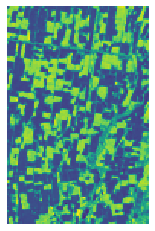

In [44]:
plt.imshow(y_pred_[143:,94:], vmin=0, vmax=1)
plt.axis('off')

(-0.5, 92.5, 142.5, -0.5)

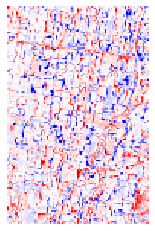

In [46]:
plt.imshow((y_pred_-y_test_)[143:,94:],vmin=-1,vmax=1,cmap='seismic_r')
plt.axis('off')
# plt.colorbar(aspect=40)

0.0938331
0.01926146
0.8586536506078383


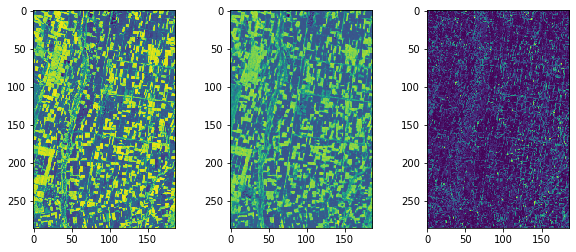

In [41]:
idx = '0524'
#     all_patch = np.load(f'../sar_2_ndvi/sentinel/{city}/bin/patch/all_{idx}.npy')
all_patch = np.load(f'/Volumes/work/沖研/satellite/sar_2_ndvi/sentinel/otofuke/bin/patch/all_{idx}.npy')
X_test, y_test = create_data_map_(all_patch)

model = create_prev_map_model()
#     model.load_weights(f'../sar_2_ndvi/sentinel/{city}/model_weight/cnn_prev_map_{model_path}.h5')
model.load_weights(f'/Volumes/work/沖研/satellite/sar_2_ndvi/sentinel/otofuke/model_weight/cnn_prev_map_{model_path}.h5')

y_pred = model.predict(X_test)
y_pred = y_pred[:, OUTPUT_MARGIN, OUTPUT_MARGIN, 0]

y_test = y_test[:, OUTPUT_MARGIN, OUTPUT_MARGIN]

print(mean_absolute_error(y_pred, y_test))
print(mean_squared_error(y_pred, y_test))
print(np.corrcoef(np.ravel(y_pred), np.ravel(y_test))[0][1])

h = 286
w = 187
plt.figure(figsize=(10,4))
plt.title(idx)
plt.subplot(1,3,1)
plt.imshow(y_test.reshape((h, w)))
plt.subplot(1,3,2)
plt.imshow(y_pred.reshape((h, w)))
plt.subplot(1,3,3)
plt.imshow(np.abs(y_test.reshape((h, w)) - y_pred.reshape((h, w))))
plt.show()







0.0938331
0.01926146
0.8586536506078383


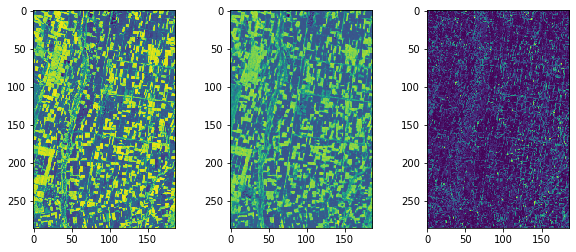

0.17966528
0.06179956
0.5789109190930266


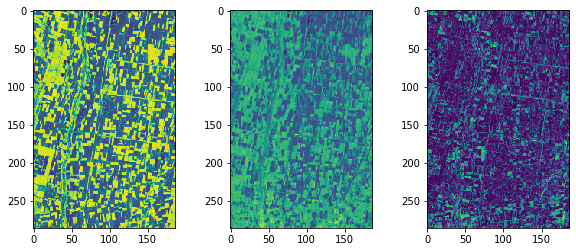

0.15754081
0.049117904
0.6794667000504844


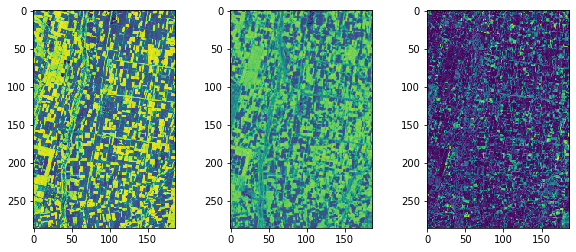

In [18]:
city = 'otofuke'
model_path = '0524'

for idx in ['0524','0528', '0605']:
#     all_patch = np.load(f'../sar_2_ndvi/sentinel/{city}/bin/patch/all_{idx}.npy')
    all_patch = np.load(f'/Volumes/work/沖研/satellite/sar_2_ndvi/sentinel/otofuke/bin/patch/all_{idx}.npy')
    X_test, y_test = create_data_map_(all_patch)
    
    model = create_prev_map_model()
#     model.load_weights(f'../sar_2_ndvi/sentinel/{city}/model_weight/cnn_prev_map_{model_path}.h5')
    model.load_weights(f'/Volumes/work/沖研/satellite/sar_2_ndvi/sentinel/otofuke/model_weight/cnn_prev_map_{model_path}.h5')
    
    y_pred = model.predict(X_test)
    y_pred = y_pred[:, OUTPUT_MARGIN, OUTPUT_MARGIN, 0]
    
    y_test = y_test[:, OUTPUT_MARGIN, OUTPUT_MARGIN]
    
    print(mean_absolute_error(y_pred, y_test))
    print(mean_squared_error(y_pred, y_test))
    print(np.corrcoef(np.ravel(y_pred), np.ravel(y_test))[0][1])
    
    h = 286
    w = 187
    plt.figure(figsize=(10,4))
    plt.title(idx)
    plt.subplot(1,3,1)
    plt.imshow(y_test.reshape((h, w)))
    plt.subplot(1,3,2)
    plt.imshow(y_pred.reshape((h, w)))
    plt.subplot(1,3,3)
    plt.imshow(np.abs(y_test.reshape((h, w)) - y_pred.reshape((h, w))))
    plt.show()

## (Linear)

In [265]:
from sklearn import linear_model

In [342]:
for idx in ['0220', '0503', '0818', '1110']:
    
    train_patch = np.load(f'../sar_2_ndvi/sentinel/tsumagoi/bin/patch/train_{idx}.npy')
    test_patch = np.load(f'../sar_2_ndvi/sentinel/tsumagoi/bin/patch/test_{idx}.npy')
    X_train, y_train, X_test, y_test = create_data_map(train_patch, test_patch)
    
    X_train = X_train[:, PATCH_MARGIN, PATCH_MARGIN, :]
    y_train = y_train[:, OUTPUT_MARGIN, OUTPUT_MARGIN]
    X_test = X_test[:, PATCH_MARGIN, PATCH_MARGIN, :]
    y_test = y_test[:, OUTPUT_MARGIN, OUTPUT_MARGIN]
    
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    mse = mean_squared_error(pred, y_test)
    mae = mean_absolute_error(pred, y_test)
    
    print(path)
    print(f'mae: {mae}, mse: {mse}')
    print('correlation coef: ', np.corrcoef(pred, y_test)[0][1])
    print(model.coef_)

../sar_2_ndvi/sentinel/tsumagoi/bin/pixel_resized/collocate_crop_0503.npy
mae: 0.11697164177894592, mse: 0.02554718405008316
correlation coef:  0.31808717966147665
[ 0.78873605 -0.41372445 -0.3841994 ]
../sar_2_ndvi/sentinel/tsumagoi/bin/pixel_resized/collocate_crop_0503.npy
mae: 0.10211993008852005, mse: 0.017223156988620758
correlation coef:  0.5760929670554206
[ 0.77924824 -0.21985784 -0.10360295]
../sar_2_ndvi/sentinel/tsumagoi/bin/pixel_resized/collocate_crop_0503.npy
mae: 0.14509056508541107, mse: 0.030835136771202087
correlation coef:  0.5726054315339101
[ 1.6839905  -0.32394433  0.17879143]
../sar_2_ndvi/sentinel/tsumagoi/bin/pixel_resized/collocate_crop_0503.npy
mae: 0.10302656143903732, mse: 0.017782552167773247
correlation coef:  0.4394772871568874
[ 0.79332304 -0.25840026  0.17355324]


# Map generation

In [146]:
# Hyperparameters
h = 426
w = 512

In [ ]:
# Save test input data in tmp dir (Memory consuming)
img_list = glob.glob('../sar_2_ndvi/sentinel/tsumagoi/bin/pixel_resized/*.npy')

for path in img_list:
    idx = path[-8:-4]
    img = np.load(path)
    img = img[:7]
    
    _, test_patch = generate_patch(img,SPACING=1)
    np.save(os.path.join(save_dir, f'tmp/test_{idx}.npy'), test_patch)

## Map by point

MAE w/o hist:  0.10984646 w hist:  0.14436490682896694
MSE w/o hist:  0.02263092 w hist:  0.036481738359941944
Coef w/o hist:  0.42321020418065475 w hist:  0.4190360884149014


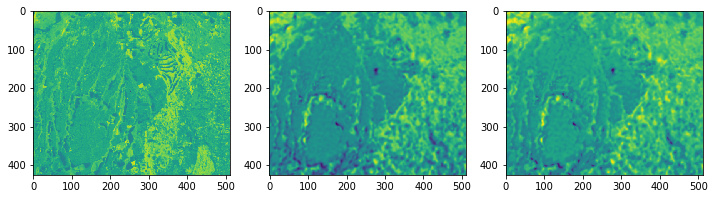

MAE w/o hist:  0.094534054 w hist:  0.11575866416147354
MSE w/o hist:  0.016835354 w hist:  0.023895991026734526
Coef w/o hist:  0.5781965901552211 w hist:  0.5500896065458325


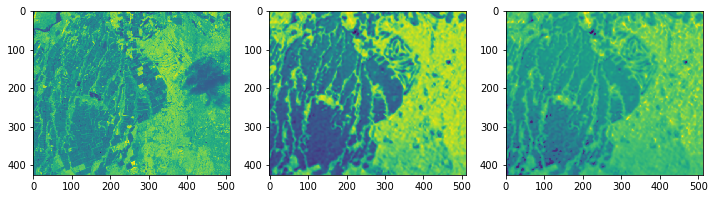

MAE w/o hist:  0.10165056 w hist:  0.11068713085312568
MSE w/o hist:  0.02073982 w hist:  0.03056629599273923
Coef w/o hist:  0.7422199904524879 w hist:  0.7112441727801655


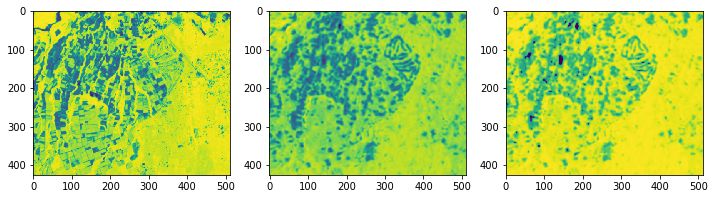

MAE w/o hist:  0.091619134 w hist:  0.10645677940640333
MSE w/o hist:  0.014787331 w hist:  0.02180873048280975
Coef w/o hist:  0.5475229019067349 w hist:  0.511993720604536


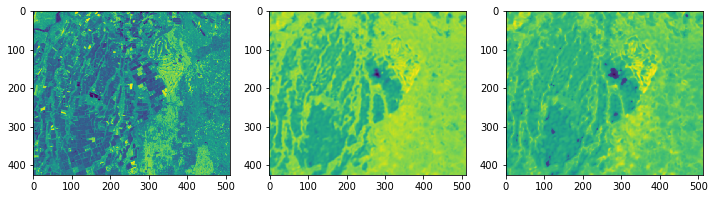

In [203]:
for idx in ['0220', '0503', '0818', '1110']:
    
    test_patch = np.load(f'../sar_2_ndvi/sentinel/tsumagoi/bin/patch/tmp/test_{idx}.npy')
    X_test, y_test = create_data_map_(test_patch)
    
    model = create_prev_map_model()
    model.load_weights(f'../sar_2_ndvi/sentinel/tsumagoi/model_weight/all_train_prev/cnn_prev_map_{idx}.h5')
    
    y_pred = model.predict(X_test)
    y_pred = y_pred[:, OUTPUT_MARGIN, OUTPUT_MARGIN, 0]
    
    y_test = y_test[:, OUTPUT_MARGIN, OUTPUT_MARGIN]
    
    print(mean_absolute_error(y_pred, y_test))
    print(mean_squared_error(y_pred, y_test))
    print(np.corrcoef(np.ravel(y_pred), np.ravel(y_test))[0][1])
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(y_test.reshape(h, w))
    plt.subplot(1,3,2)
    plt.imshow(y_pred.reshape(h, w))
    plt.subplot(1,3,3)
    plt.imshow(np.abs(y_test.reshape((h, w)) - y_pred.reshape((h, w))))
    plt.show()

0.0763009
0.011905878
0.2536491968516266


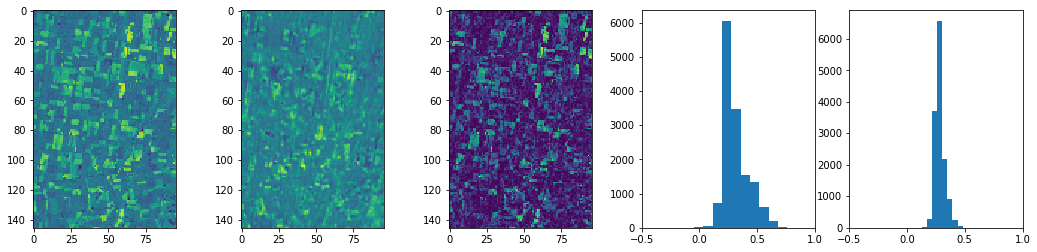

0.10606262
0.024148524
0.8265983370149412


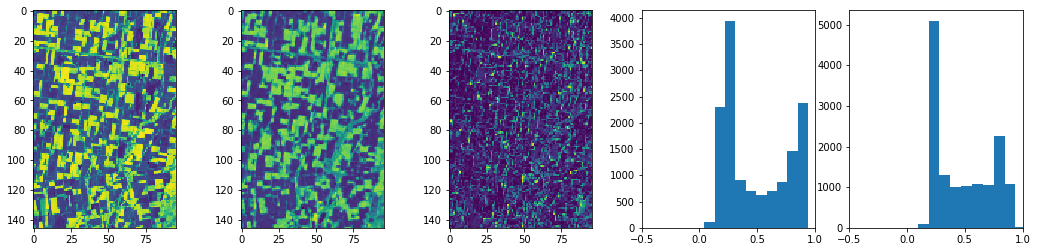

0.16941524
0.05427106
0.564692080090252


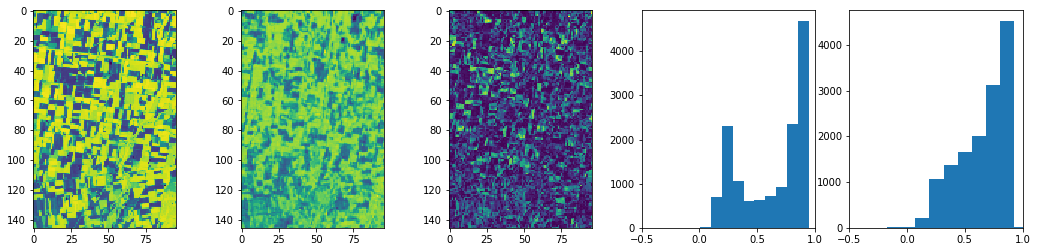

0.13959928
0.031794228
0.4772317919429283


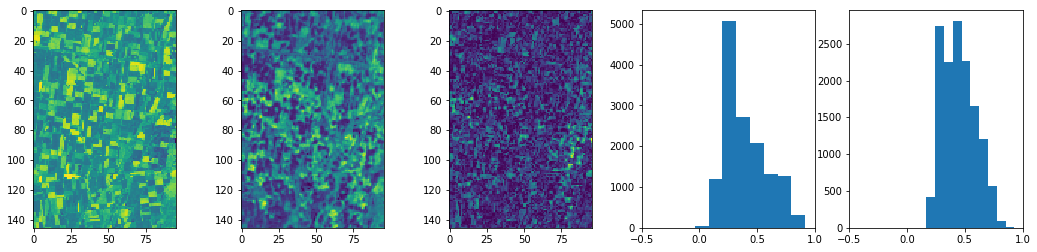

In [223]:
city = 'otofuke'
h = 146 # 286
w = 96 # 187

for idx in ['0329','0524', '0820', '1108']:
    
    test_patch = np.load(f'../sar_2_ndvi/sentinel/{city}/bin/patch/test_{idx}.npy')
    X_test, y_test = create_data_map_(test_patch)
    
    model = create_prev_map_model()
    model.load_weights(f'../sar_2_ndvi/sentinel/{city}/model_weight/cnn_prev_map_{idx}.h5')
    
    y_pred = model.predict(X_test)
    y_pred = y_pred[:, OUTPUT_MARGIN, OUTPUT_MARGIN, 0]
    
    y_test = y_test[:, OUTPUT_MARGIN, OUTPUT_MARGIN]
    
    print(mean_absolute_error(y_pred, y_test))
    print(mean_squared_error(y_pred, y_test))
    print(np.corrcoef(np.ravel(y_pred), np.ravel(y_test))[0][1])
    
    plt.figure(figsize=(18,4))
    plt.subplot(1,5,1)
    plt.imshow(y_test.reshape(h, w))
    plt.subplot(1,5,2)
    plt.imshow(y_pred.reshape(h, w))
    plt.subplot(1,5,3)
    plt.imshow(np.abs(y_test.reshape((h, w)) - y_pred.reshape((h, w))))
    plt.subplot(1,5,4)
    plt.xlim(-0.5, 1)
    plt.hist(y_test)
    plt.subplot(1,5,5)
    plt.xlim(-0.5, 1)
    plt.hist(y_pred)
    plt.show()

0.0890558
0.015615649
0.5522150254943525


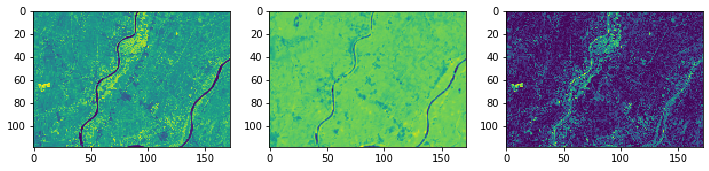

0.101155534
0.021533607
0.6338366754650401


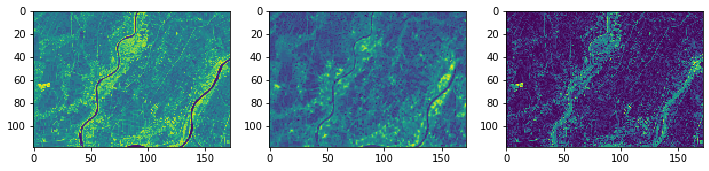

0.115346424
0.02626894
0.7101457931131273


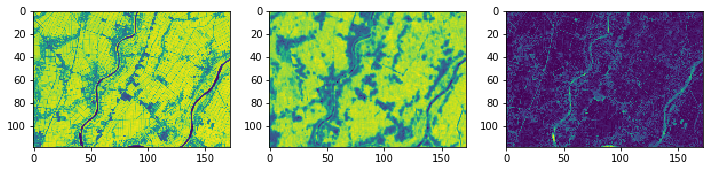

0.10609653
0.020124145
0.5109645104553119


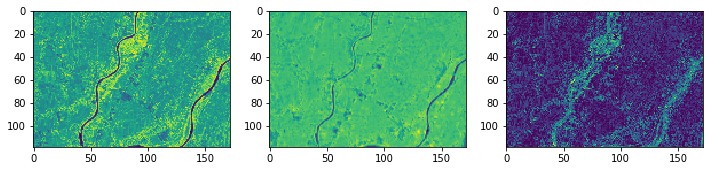

In [634]:
city = 'niigata'
h = 119
w = 172

for idx in ['0328', '0502', '0807', '1117']:
    
    test_patch = np.load(f'../sar_2_ndvi/sentinel/{city}/bin/patch/test_{idx}.npy')
    X_test, y_test = create_data_map_(test_patch)
    
    model = create_prev_map_model()
    model.load_weights(f'../sar_2_ndvi/sentinel/{city}/model_weight/cnn_prev_map_{idx}.h5')
    
    y_pred = model.predict(X_test)
    y_pred = y_pred[:, OUTPUT_MARGIN, OUTPUT_MARGIN, 0]
    
    y_test = y_test[:, OUTPUT_MARGIN, OUTPUT_MARGIN]
    
    print(mean_absolute_error(y_pred, y_test))
    print(mean_squared_error(y_pred, y_test))
    print(np.corrcoef(np.ravel(y_pred), np.ravel(y_test))[0][1])
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(y_test.reshape(h, w))
    plt.subplot(1,3,2)
    plt.imshow(y_pred.reshape(h, w))
    plt.subplot(1,3,3)
    plt.imshow(np.abs(y_test.reshape((h, w)) - y_pred.reshape((h, w))))
    plt.show()

0.07748653
0.0121522425
0.8614117313533763


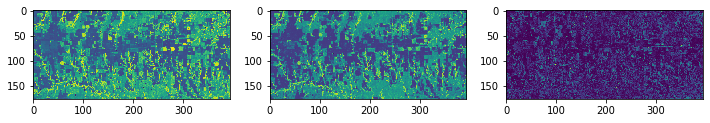

In [669]:
city = 'kansas'
h = 177
w = 394

for idx in ['0626']:
    
    test_patch = np.load(f'../sar_2_ndvi/sentinel/{city}/bin/patch/test_{idx}.npy')
    X_test, y_test = create_data_map_(test_patch)
    
    model = create_prev_map_model()
    model.load_weights(f'../sar_2_ndvi/sentinel/{city}/model_weight/cnn_prev_map_{idx}.h5')
    
    y_pred = model.predict(X_test)
    y_pred = y_pred[:, OUTPUT_MARGIN, OUTPUT_MARGIN, 0]
    
    y_test = y_test[:, OUTPUT_MARGIN, OUTPUT_MARGIN]
    
    print(mean_absolute_error(y_pred, y_test))
    print(mean_squared_error(y_pred, y_test))
    print(np.corrcoef(np.ravel(y_pred), np.ravel(y_test))[0][1])
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(y_test.reshape(h, w))
    plt.subplot(1,3,2)
    plt.imshow(y_pred.reshape(h, w))
    plt.subplot(1,3,3)
    plt.imshow(np.abs(y_test.reshape((h, w)) - y_pred.reshape((h, w))))
    plt.show()

## Map by point (histogram)

0.07903666
0.012998385
0.2025224679919976


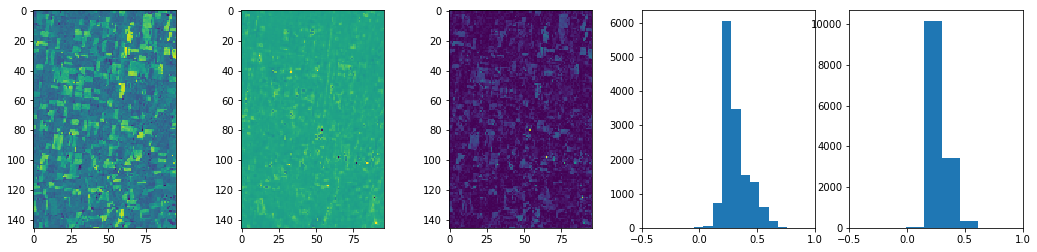

0.10415488
0.025506282
0.8224572867690567


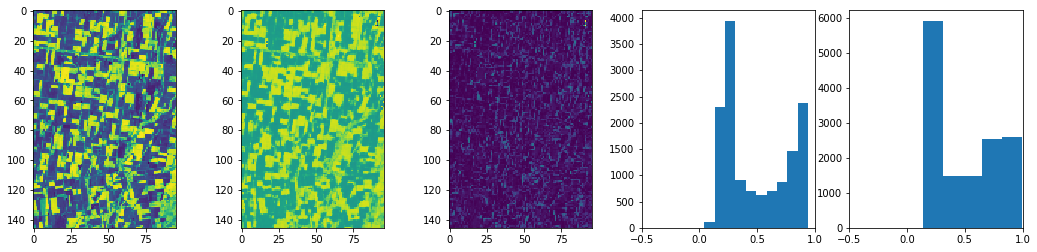

0.1740599
0.064705275
0.5215263780440594


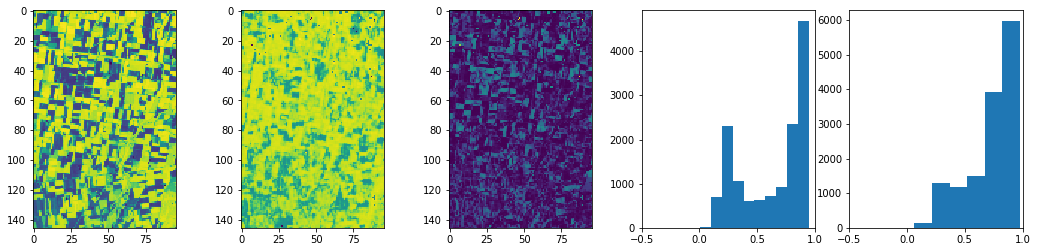

In [543]:
city = 'otofuke'
h = 146 # 286
w = 96 # 187

for idx in ['0329','0524', '0820', '1108']:
    
    test_patch = np.load(f'../sar_2_ndvi/sentinel/{city}/bin/patch/test_{idx}.npy')
    X_test, y_test = create_data_map_(test_patch)
    
    model = create_prev_map_model()
    model.load_weights(f'../sar_2_ndvi/sentinel/{city}/model_weight/hist/cnn_prev_map_{idx}.h5')
    
    y_pred = model.predict(X_test)
    y_pred = y_pred[:, OUTPUT_MARGIN, OUTPUT_MARGIN, 0]
    
    y_test = y_test[:, OUTPUT_MARGIN, OUTPUT_MARGIN]
    
    with open(f'../sar_2_ndvi/sentinel/{city}/bin/patch_hist/cdf/train_{idx}_cdf.pickle', 'rb') as f:
        cdf = pickle.load(f)
    y_pred = hist_revision(y_pred, cdf, img_min=-1, img_max=1)
    
    print(mean_absolute_error(y_pred, y_test))
    print(mean_squared_error(y_pred, y_test))
    print(np.corrcoef(np.ravel(y_pred), np.ravel(y_test))[0][1])
    
    plt.figure(figsize=(18,4))
    plt.subplot(1,5,1)
    plt.imshow(y_test.reshape(h, w))
    plt.subplot(1,5,2)
    plt.imshow(y_pred.reshape(h, w))
    plt.subplot(1,5,3)
    plt.imshow(np.abs(y_test.reshape((h, w)) - y_pred.reshape((h, w))))
    plt.subplot(1,5,4)
    plt.xlim(-0.5, 1)
    plt.hist(y_test)
    plt.subplot(1,5,5)
    plt.xlim(-0.5, 1)
    plt.hist(y_pred)
    plt.show()